In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
%matplotlib inline
sns.set_palette("Pastel2")

## 1. 데이터 로딩 / データのロード

- Data can be obtained from:
- https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset

In [2]:
df = pd.read_csv("players_20.csv")

## 2. 데이터 전처리 / データの前処理

### Selecting columns

In [3]:
COLUMNS = ["value_eur",  # target variable
           "sofifa_id", "short_name", "nationality", "club",  # metadata
           "overall", "potential", "international_reputation",  # evaluation
           "wage_eur", "contract_valid_until",  # contract info.
           "player_positions",  # positions
           "preferred_foot", "weak_foot", "age", "height_cm", "weight_kg",  # physical info.
           "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy",
           "attacking_short_passing", "attacking_volleys",  # attacking stats
           "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control",  # skill stats
           "movement_acceleration", "movement_sprint_speed", "movement_agility",
           "movement_reactions", "movement_balance",  # movement stats
           "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots",  # power stats
           "mentality_aggression", "mentality_interceptions", "mentality_positioning",
           "mentality_vision", "mentality_penalties","mentality_composure",  # mental stats
           "defending_marking", "defending_standing_tackle", "defending_sliding_tackle"]  # defending stats

In [4]:
df = df.loc[:, COLUMNS]

### Missing values

- Drop data because the number of missing values is small.

In [5]:
for col, value in df.isnull().sum().iteritems():
    if value > 0:
        print(col, value)

contract_valid_until 240


In [6]:
df = df.dropna(how="any")

### Contract

- Instead of using the "contract_valid_until", calculate and use the remaining contract period.

In [7]:
df["contract_duration"] = df["contract_valid_until"] - 2020
df["contract_duration"] = df["contract_duration"].astype("int64")
df = df.drop("contract_valid_until", axis=1)

### Preferred foot

In [8]:
df.loc[:, "preferred_foot"] = df["preferred_foot"].apply(lambda x: 1 if x == "Right" else 0).values

### Positions

- GK is excluded because it uses different stats from other positions.

In [9]:
df = df.loc[df["player_positions"] != "GK", :]

- Convert possible positions to 1 and otherwise to 0.

In [10]:
df_positions = pd.concat([df[["sofifa_id"]], df["player_positions"].str.split(", ", expand=True)], axis=1)
df_positions.columns = ["sofifa_id", "position_1", "position_2", "position_3"]

In [11]:
POSITIONS = ['ST', 'CF', 'LW', 'LM', 'RW', 'RM', 'CAM', 'CM', 'CDM', 'LB', 'LWB', 'CB', 'RB', 'RWB']
for pos in POSITIONS:
    df_positions.loc[:, pos] = df_positions.apply(lambda x: 1 if (x[1] == pos) or (x[2] == pos) or (x[3] == pos) else 0, axis=1).values
df_positions = df_positions.drop(["position_1", "position_2", "position_3"], axis=1)

In [12]:
df = pd.merge(df.drop("player_positions", axis=1), df_positions, on="sofifa_id")
df.head()

,value_eur,sofifa_id,short_name,nationality,club,overall,potential,international_reputation,wage_eur,preferred_foot,...,RW,RM,CAM,CM,CDM,LB,LWB,CB,RB,RWB
0,95500000,158023,L. Messi,Argentina,FC Barcelona,94,94,5,565000,0,...,1,0,0,0,0,0,0,0,0,0
1,58500000,20801,Cristiano Ronaldo,Portugal,Juventus,93,93,5,405000,1,...,0,0,0,0,0,0,0,0,0,0
2,105500000,190871,Neymar Jr,Brazil,Paris Saint-Germain,92,92,5,290000,1,...,0,0,1,0,0,0,0,0,0,0
3,90000000,183277,E. Hazard,Belgium,Real Madrid,91,91,4,470000,1,...,0,0,0,0,0,0,0,0,0,0
4,90000000,192985,K. De Bruyne,Belgium,Manchester City,91,91,4,370000,1,...,0,0,1,1,0,0,0,0,0,0


## 3. 탐색적 자료 분석 / 探索的データ解析

### Value

- Mbappé is young but the third most valuable player.

In [13]:
df[["value_eur", "short_name", "nationality", "club", "age"]].sort_values(by="value_eur", ascending=False).head()

,value_eur,short_name,nationality,club,age
2,105500000,Neymar Jr,Brazil,Paris Saint-Germain,27
0,95500000,L. Messi,Argentina,FC Barcelona,32
8,93500000,K. Mbappé,France,Paris Saint-Germain,20
3,90000000,E. Hazard,Belgium,Real Madrid,28
4,90000000,K. De Bruyne,Belgium,Manchester City,28


### Nationality

- There are the most players from England, but the overall ratings are not high.

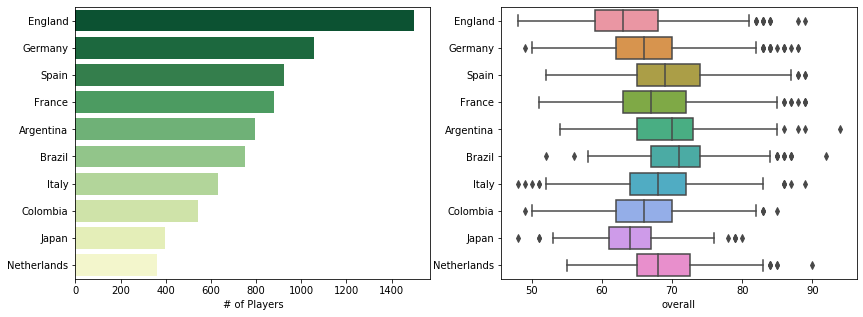

In [14]:
top10_country = df["nationality"].value_counts()[:10].index
top10_df = df.loc[df["nationality"].isin(top10_country), ["nationality", "overall"]]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(y=df["nationality"].value_counts().index[:10], x=df["nationality"].value_counts()[:10], ci=None, orient="h", palette="YlGn_r", ax=ax[0])
ax[0].set_xlabel("# of Players")

sns.boxplot(x=top10_df["overall"], y=top10_df["nationality"], order=top10_country, ax=ax[1])
ax[1].set_ylabel("")
plt.show()

### Club

- Real Madrid has the highest average wage, as well as the second highest average overall.

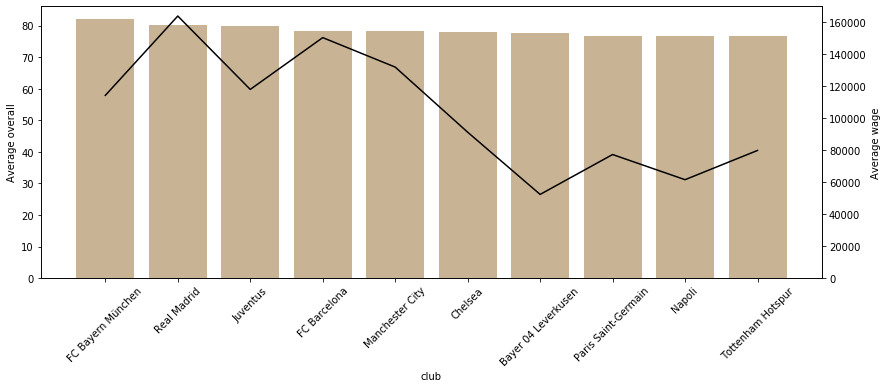

In [15]:
club_df = df[["club", "overall", "wage_eur"]].groupby("club").mean().sort_values(by="overall", ascending=False)

fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x=club_df.index[:10], y=club_df["overall"][:10], order=club_df.index[:10], ci=None, ax=ax, color="tan")
ax.set_ylabel("Average overall")
plt.xticks(rotation=45)

ax2 = ax.twinx()
sns.lineplot(x=club_df.index[:10], y=club_df["wage_eur"][:10], ci=None, ax=ax2, color="k", sort=False)
plt.ylim([0, 170000])
ax2.set_ylabel("Average wage")
plt.show()

### Age

- The distribution of wages does not seem to change much after the age of 25.

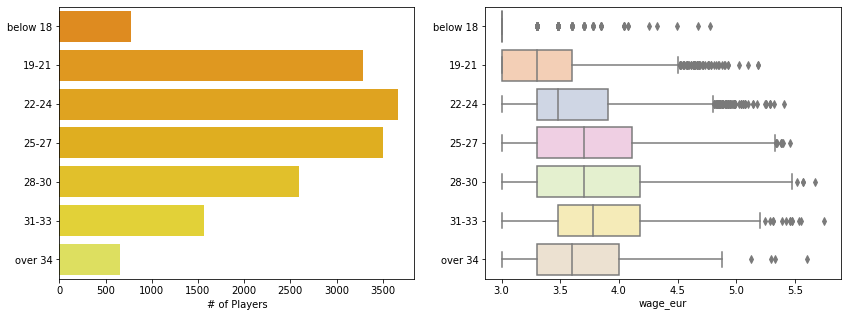

In [16]:
age_bins = [0, 18, 21, 24, 27, 30, 33, 100]
age_labels = ["below 18", "19-21", "22-24", "25-27", "28-30", "31-33", "over 34"]
age_df = df.loc[:, ["wage_eur", "age"]]
age_df.loc[:, "age_group"] = pd.cut(age_df["age"], bins=age_bins, labels=age_labels).values

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=age_df["age_group"].value_counts(), y=age_df["age_group"].value_counts().index, order=age_labels, ci=None, palette="Wistia_r", ax=ax[0])
ax[0].set_xlabel("# of Players")

sns.boxplot(x=np.log10(age_df["wage_eur"]), y=age_df["age_group"], order=age_labels, ax=ax[1])
ax[1].set_ylabel("")
plt.show()

## Preferred foot

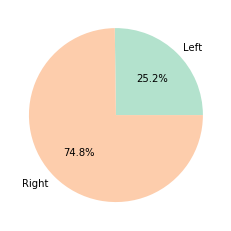

In [17]:
foot_count = df["preferred_foot"].value_counts().sort_index()
foot_count.index = ["Left", "Right"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(foot_count.values, labels=foot_count.index, autopct="%1.1f%%")
plt.show()

### Height & Weight

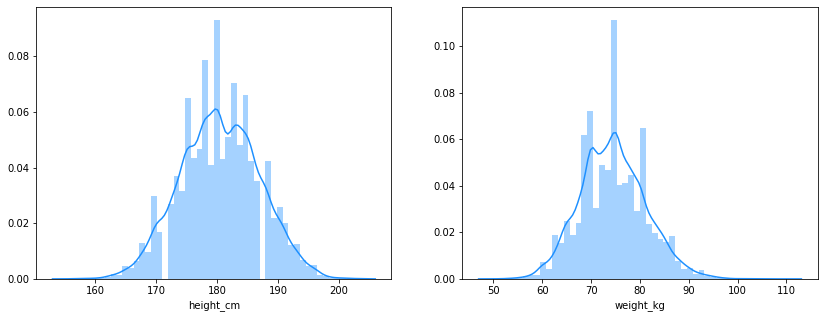

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(df["height_cm"], ax=ax[0], color="dodgerblue")
sns.distplot(df["weight_kg"], ax=ax[1], color="dodgerblue")
plt.show()

### Positions

In [19]:
values = []
for pos in POSITIONS:
    values.append((df["value_eur"] * df[pos]).sum())

position_df = pd.DataFrame(df.loc[:, POSITIONS].sum(), columns=["player_count"])
position_df["total_value"] = values
position_df["average_value"] = position_df["total_value"] / position_df["player_count"]

- As we know in common sense, the average value is expensive in the order of the attacker, midfielder, and defender.
- Despite the small number of players in the CF position, the high average value is due to Lionel Messi.

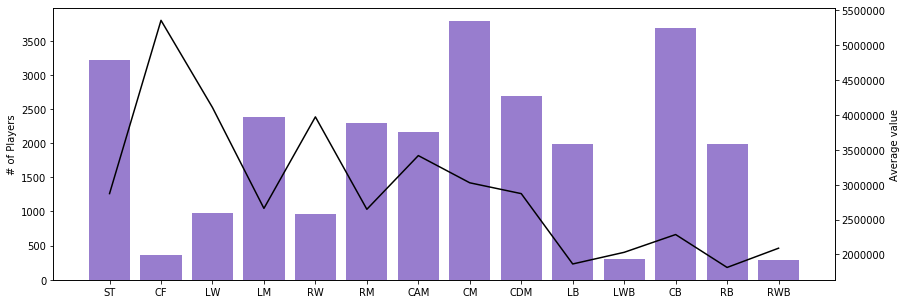

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x=position_df.index, y=position_df["player_count"], order=position_df.index, ci=None, ax=ax, color="mediumpurple")
ax.set_ylabel("# of Players")

ax2 = ax.twinx()
sns.lineplot(x=position_df.index, y=position_df["average_value"], ci=None, ax=ax2, color="k", sort=False)
ax2.set_ylabel("Average value")
plt.show()

## 4. 회귀 분석  / 回帰分析

### Predict the value of players

#### Regression using only the stats

In [13]:
X = df.loc[:, "attacking_crossing":"defending_sliding_tackle"]
y = df["value_eur"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
# You can use the Grid Search.
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8793995994538304

- The importance of the movement reactions was measured most.

In [15]:
for i in np.argsort(rf.feature_importances_)[::-1][:5]:
    print("{}: {}".format(X.columns[i], rf.feature_importances_[i]))

movement_reactions: 0.637009047259995
skill_ball_control: 0.1327392251697303
defending_standing_tackle: 0.03968391863081786
movement_sprint_speed: 0.019243430007018034
skill_dribbling: 0.013249941260549907


#### Regression adding the wage, positions, etc.

In [16]:
X = df.loc[:, "international_reputation":"RWB"]
y = df["value_eur"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9063303872402684

- Since the wage reflects the current value of the player, it was measured most importantly.

In [18]:
for i in np.argsort(rf.feature_importances_)[::-1][:5]:
    print("{}: {}".format(X.columns[i], rf.feature_importances_[i]))

wage_eur: 0.6359561433258363
movement_reactions: 0.13487045884569052
skill_ball_control: 0.06470773100707615
age: 0.03271935996876528
defending_standing_tackle: 0.0118124060983985


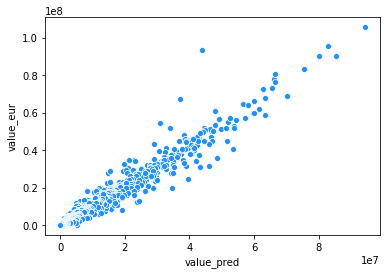

In [19]:
predict_df = df.loc[:, ["short_name", "nationality", "club", "age", "wage_eur", "value_eur"]]
predict_df["value_pred"] = rf.predict(X)
sns.scatterplot(x="value_pred", y="value_eur", data=predict_df, color="dodgerblue")

- Extract the players whose predicted value is significantly different from the actual value.
- This is the case where the current wage is very low compared to the value due to age, etc.

In [20]:
predict_df.loc[predict_df["value_eur"] >= predict_df["value_pred"] * 2, :].sort_values(by="value_eur", ascending=False).head()

,short_name,nationality,club,age,wage_eur,value_eur,value_pred
8,K. Mbappé,France,Paris Saint-Germain,20,155000,93500000,43810000.0
252,S. Kjær,Denmark,Sevilla FC,30,24000,18000000,8422500.0
332,B. Höwedes,Germany,Lokomotiv Moscow,31,1000,13000000,6065750.0
1414,N. Domínguez,Argentina,Vélez Sarsfield,21,11000,12000000,4916375.0
1869,J. David,Canada,KAA Gent,19,12000,10500000,5211000.0
